In [409]:
import yfinance as yf
import numpy as np
import pandas as pd
import datetime as dt
import warnings
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [544]:
def plotPercentagereturn(data):
    ((data[np.abs(data) < 2]-1)*100).hist(bins=100, figsize=(25,10), density=True)
    plt.xlim([-100, 100])
    plt.xlabel('returns [%]')
    plt.ylabel('frequency')
    
def yearlyYeildPercent(val):
    return (((val + 1) ** 52) - 1)*100

def downloadData(noTickers, start, end, interval):
    tickers = pd.read_csv("../nasdaqTickers.csv")
    data = pd.DataFrame()
    warnings.filterwarnings("ignore")

    ticker_codes = tickers.sample(noTickers)['Symbol']
    realNoTickers = 0
    for code in ticker_codes:
        currdata = yf.download(code, start=start, end=end, interval=interval, progress=False)
        if len(currdata) > 0:
            currdata['next_close'] = np.nan
            currdata.loc[:-1,'next_close'] = currdata.iloc[1:].Close.values
            currdata.loc[:-1,'next_open'] = currdata.iloc[1:].Open.values 
            data = pd.concat([data, currdata])
            realNoTickers +=1
    warnings.filterwarnings("default")
    return realNoTickers, data

def downloadDataTicker(code, start, end, interval):
    tickers = pd.read_csv("../nasdaqTickers.csv")
    currdata = yf.download(code, start=start, end=end, interval=interval, progress=False)
    
    currdata['next_close'] = np.nan
    currdata.loc[:-1,'next_close'] = currdata.iloc[1:].Close.values
    currdata.loc[:-1,'next_open'] = currdata.iloc[1:].Open.values 

    return 1, currdata

def normalizeData(data):
    dataNorm = data.drop(columns=['Adj Close','Volume'])
    columns = ['Open',	'High',	'Low',	'Close', 'next_close','next_open']

    normFactor = data['Open'].values
    for c in columns:
        dataNorm[c] = dataNorm[c]/normFactor
    return dataNorm

def plotHists(dataNorm):
    plt.subplot(2,2,1)
    plotPercentagereturn(dataNorm['next_close'])
    plt.title("avg next close")
    plt.subplot(2,2,2)
    plotPercentagereturn(dataNorm[dataNorm['Close']>1]['next_close'])
    plt.title("avg next close when: close > open")
    plt.subplot(2,2,3)
    plotPercentagereturn(dataNorm[(dataNorm['Close']<1) & (dataNorm['Low']==dataNorm['Close'])]['next_close'])
    plt.title("avg next close when: close < open and low=close")
    plt.subplot(2,2,4)
    plotPercentagereturn(dataNorm[(dataNorm['Close']>1) & (dataNorm['High']==dataNorm['Close'])]['next_close'])
    plt.title("avg next close when: close < open and high=close")
    plt.show()

def runML(dataNorm, interval, spy_return, start, end, noTickers):
    # data
    MLdata = dataNorm.dropna()
    X = MLdata[['High', 'Low', 'Close', 'next_open']]
    y = MLdata['next_close']
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
    divider = int(0.7*len(X))
    X_train, X_test = X[:divider], X[divider:]
    y_train, y_test = y[:divider], y[divider:]
    summary = X_test
    X_train, X_test, y_train, y_test = X_train.drop(columns='next_open'), X_test.drop(columns='next_open'), y_train.drop(columns='next_open'), y_test.drop(columns='next_open')

    # model
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # performance
    err = mean_squared_error(y_test, y_pred)

    summary['pred'] = y_pred
    summary['real'] = y_test
    summary[summary['pred'] < summary['next_open']]
    summary['resultLong'] = 0
    summary['resultShort'] = 0
    summary['result_benchmark'] = 0

    # LONG
    idx = summary['next_open'] > (summary['pred'])
    summary.loc[idx, 'resultLong'] = summary[idx]['real'] - summary[idx]['next_open']

    # SHORT
    idx = summary['next_open'] < (summary['pred'])
    summary.loc[idx, 'resultShort'] = summary[idx]['next_open'] - summary[idx]['real']

    # LONG
    summary['result_benchmark'] = summary['real'] - summary['next_open']

    resultLong = summary['resultLong'].mean()*100
    resultShort = summary['resultShort'].mean()*100
    resultBenchmark = summary['result_benchmark'].mean()*100

    resultLongYr = yearlyYeildPercent(summary['resultLong'].mean())
    resultShortYr = yearlyYeildPercent(summary['resultShort'].mean())
    resultBenchmarkYr = yearlyYeildPercent(summary['result_benchmark'].mean())

    print(f"Result per timeframe: {interval}\nlong: {resultLong:.2f}%\nshort: {resultShort:.2f}%\nbenchmark: {resultBenchmark:.2f}%\n")
    print(f"""Result per year:\nlong: {resultLongYr:.2f}%\nshort: {resultShortYr:.2f}%\nbenchmark: {resultBenchmarkYr:.2f}%""")
    return pd.DataFrame({'start':[start], 'end':[end], 'noTickers':[noTickers], 'interval':[interval], 'SPY%':[spy_return], 'resultLong%':[resultLong], 'resultShort%':[resultShort], 'resultBenchmark%':[resultBenchmark], 'resultLongYr%':[resultLongYr], 'resultShortYr%':[resultShortYr], 'resultBenchmarkYr%':[resultBenchmarkYr]})

def showSPY(start, end, interval):
    SPY = yf.download('SPY', start=start, end=end, interval=interval, progress=False)
    spy_return = (SPY.tail(1).Close.values-SPY['Close'][0])[0]/SPY['Close'][0]*100
    plt.figure(figsize=(25,10))
    plt.grid()
    plt.plot(SPY['Close'])
    plt.title(f"buy and hold {spy_return:.2f}%")
    plt.show()
    return spy_return

In [ ]:
['start', 'end', 'noTickers', 'interval', 'SPY', 'resultLong', 'resultShort', 'resultBenchmark', 'resultLongYr', 'resultShortYr', 'resultBenchmarkYr']

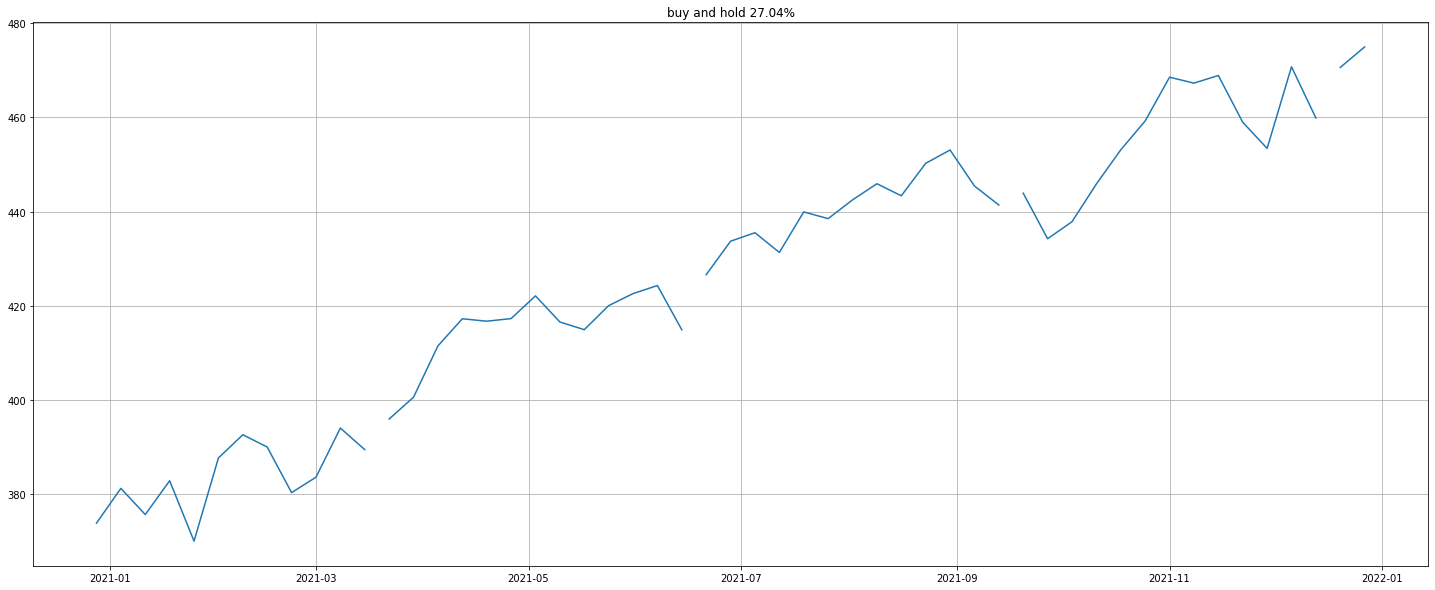

C:\Users\QbaSo\AppData\Local\Temp\ipykernel_19664\2179948130.py:33: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  currdata.loc[:-1,'next_close'] = currdata.iloc[1:].Close.values
C:\Users\QbaSo\AppData\Local\Temp\ipykernel_19664\2179948130.py:34: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  currdata.loc[:-1,'next_open'] = currdata.iloc[1:].Open.values


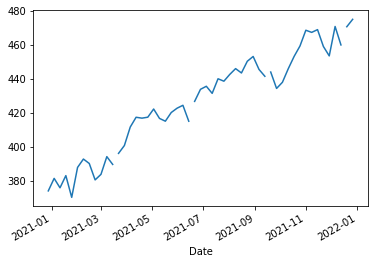

c:\Users\QbaSo\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


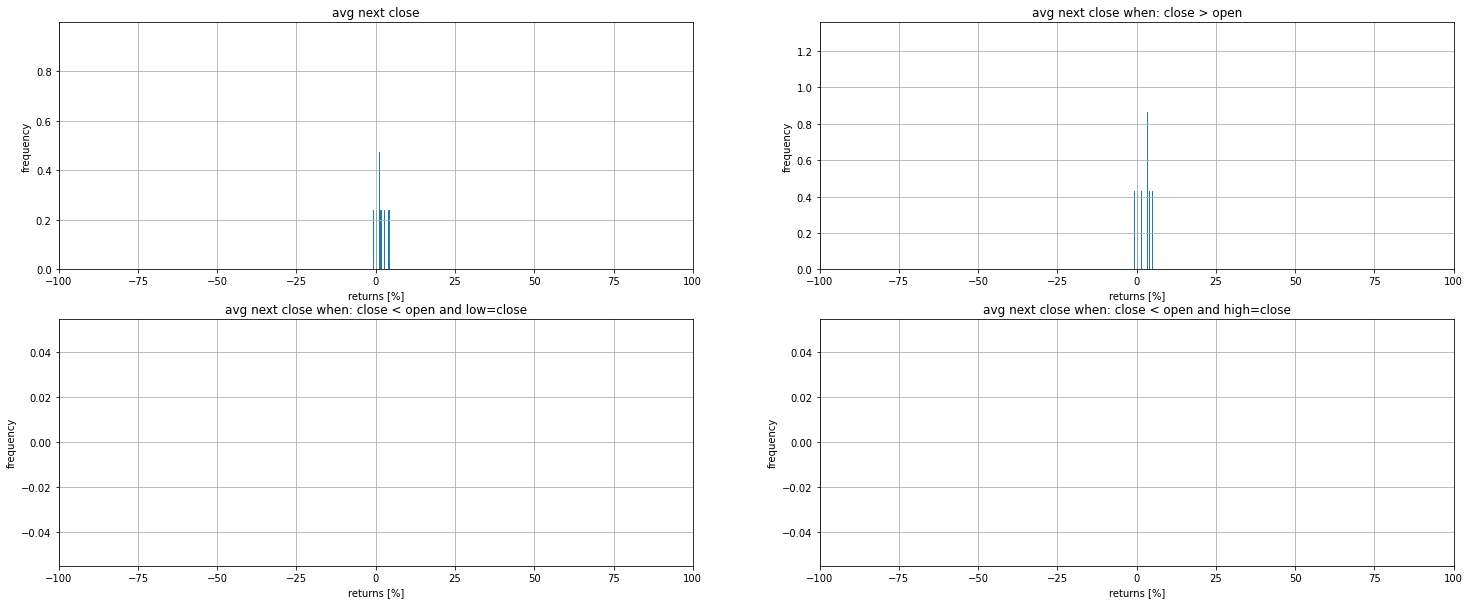

Result per timeframe: 1wk
long: -0.05%
short: 0.01%
benchmark: -0.05%

Result per year:
long: -2.33%
short: 0.44%
benchmark: -2.75%


C:\Users\QbaSo\AppData\Local\Temp\ipykernel_19664\2179948130.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary['pred'] = y_pred
C:\Users\QbaSo\AppData\Local\Temp\ipykernel_19664\2179948130.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary['real'] = y_test
C:\Users\QbaSo\AppData\Local\Temp\ipykernel_19664\2179948130.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

,start,end,noTickers,interval,SPY%,resultLong%,resultShort%,resultBenchmark%,resultLongYr%,resultShortYr%,resultBenchmarkYr%
0,2021-01-01,2022-01-01,1,1wk,27.035408,-0.045243,0.008414,-0.053657,-2.325704,0.438481,-2.752346


In [549]:
start=dt.datetime(2021,1,1)
end=dt.datetime(2022,1,1)
interval='1wk'
code = 'SPY'
spy_return = showSPY(start, end, interval)
realNoTickers, data = downloadDataTicker(code, start, end, interval)
data['Close'].plot()
plt.show()
dataNorm = normalizeData(data)
plotHists(dataNorm)
runML(dataNorm, interval, spy_return, start, end, realNoTickers)

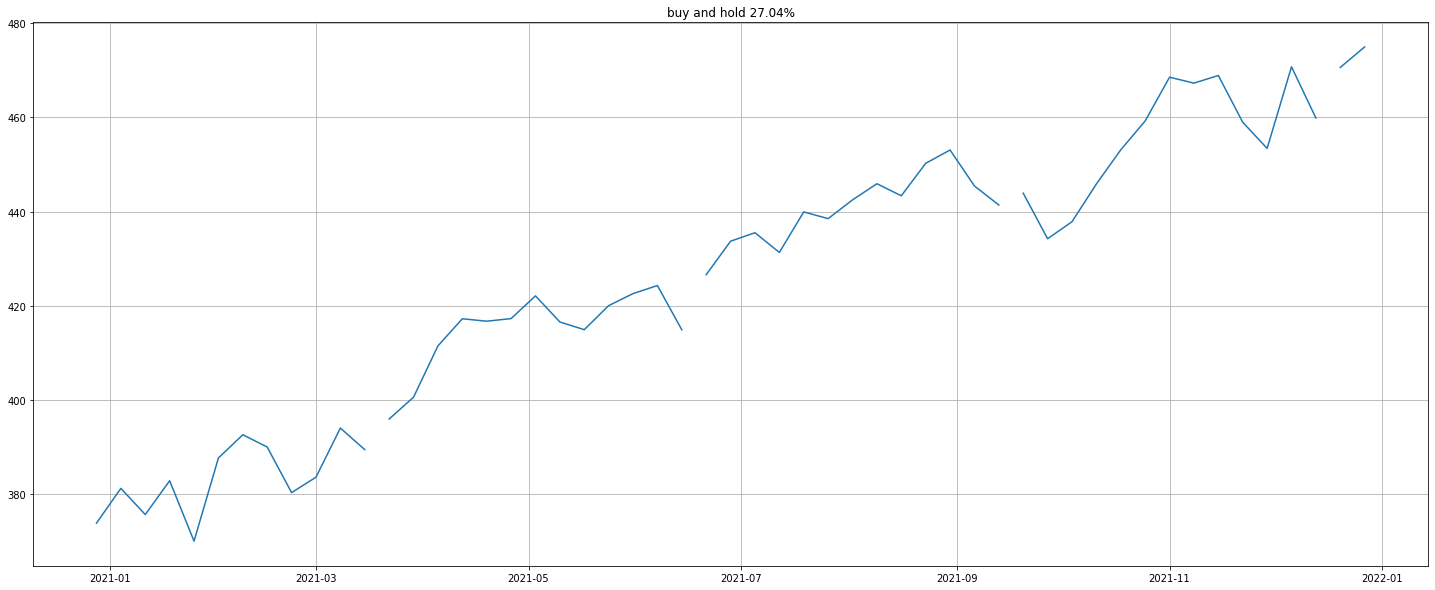


1 Failed download:
- FEXDR: No data found for this date range, symbol may be delisted

1 Failed download:
- HCMA: Data doesn't exist for startDate = 1609455600, endDate = 1640991600

1 Failed download:
- BKDT: Data doesn't exist for startDate = 1609455600, endDate = 1640991600

1 Failed download:
- SCUA: Data doesn't exist for startDate = 1609455600, endDate = 1640991600

1 Failed download:
- ADOCW: No data found for this date range, symbol may be delisted

1 Failed download:
- WHLRL: No data found for this date range, symbol may be delisted

1 Failed download:
- RCACW: No data found for this date range, symbol may be delisted

1 Failed download:
- KERNW: No data found for this date range, symbol may be delisted

1 Failed download:
- COMSW: No data found for this date range, symbol may be delisted

1 Failed download:
- GBRGW: No data found for this date range, symbol may be delisted

1 Failed download:
- CLINU: Data doesn't exist for startDate = 1609455600, endDate = 1640991600

1 Fai

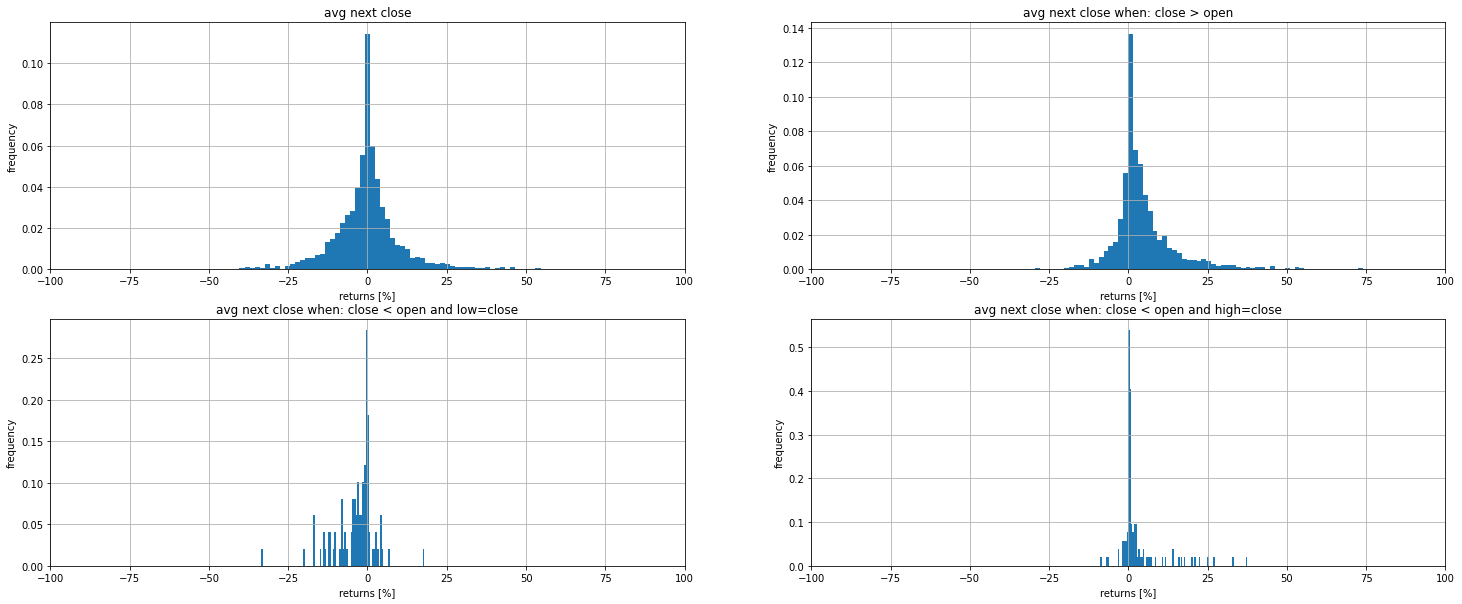

Result per timeframe: 1wk
long: -0.27%
short: 0.12%
benchmark: -0.39%

Result per year:
long: -13.21%
short: 6.42%
benchmark: -18.47%


,start,end,noTickers,interval,SPY%,resultLong%,resultShort%,resultBenchmark%,resultLongYr%,resultShortYr%,resultBenchmarkYr%
0,2021-01-01,2022-01-01,79,1wk,27.035408,-0.272088,0.119758,-0.391846,-13.21,6.421443,-18.466839


In [539]:
start=dt.datetime(2021,1,1)
end=dt.datetime(2022,1,1)
interval='1wk'
noTickers = 100
spy_return = showSPY(start, end, interval)
realNoTickers, data = downloadData(noTickers, start, end, interval)
dataNorm = normalizeData(data)
plotHists(dataNorm)
runML(dataNorm, interval, spy_return, start, end, realNoTickers)

# DEV

In [570]:
# data
MLdata = dataNorm.dropna()
X = MLdata[['High', 'Low', 'Close', 'next_open']]
y = MLdata['next_close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
summary = X_test
X_train, X_test, y_train, y_test = X_train.drop(columns='next_open'), X_test.drop(columns='next_open'), y_train.drop(columns='next_open'), y_test.drop(columns='next_open')

# model
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# performance
err = mean_squared_error(y_test, y_pred)
print(f"MAE: {err*100}")

from  xgboost import XGBRegressor
# model
model = XGBRegressor(n_estimators=10000, max_depth=700, eta=0.1, subsample=0.6, colsample_bytree=0.1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# performance
err = mean_squared_error(y_test, y_pred)
print(f"MAE: {err*100}")
summary['pred'] = y_pred
summary['real'] = y_test
summary[summary['pred'] < summary['next_open']]
summary['resultLong'] = 0
summary['resultShort'] = 0
summary['result_benchmark'] = 0

# LONG
idx = summary['next_open'] > (summary['pred'])
summary.loc[idx, 'resultLong'] = summary[idx]['real'] - summary[idx]['next_open']

# SHORT
idx = summary['next_open'] < (summary['pred'])
summary.loc[idx, 'resultShort'] = summary[idx]['next_open'] - summary[idx]['real']

# LONG
summary['result_benchmark'] = summary['real'] - summary['next_open']

print(f"Result per timeframe:\nlong: {summary['resultLong'].mean()*100:.2f}%\nshort: {summary['resultShort'].mean()*100:.2f}%\nbenchmark: {summary['result_benchmark'].mean()*100:.2f}%")
print(f"""Result per year:\nlong: {yearlyYeildPercent(summary['resultLong'].mean()):.2f}%
short: {yearlyYeildPercent(summary['resultShort'].mean()):.2f}%
benchmark: {yearlyYeildPercent(summary['result_benchmark'].mean()):.2f}%""")

MAE: 0.035345417024101565
MAE: 0.0363412459515043
Result per timeframe:
long: 0.03%
short: -0.29%
benchmark: 0.31%
Result per year:
long: 1.42%
short: -13.83%
benchmark: 17.64%


In [313]:
MLdata = dataNorm.dropna()

In [314]:
X = MLdata[['High', 'Low', 'Close', 'next_open']]
y = MLdata['next_close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
summary = X_test
X_train, X_test, y_train, y_test = X_train.drop(columns='next_open'), X_test.drop(columns='next_open'), y_train.drop(columns='next_open'), y_test.drop(columns='next_open')

In [315]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [316]:
mean_squared_error(y_test, y_pred)

0.006336091426768466

In [377]:
summary['pred'] = y_pred
summary['real'] = y_test
summary[summary['pred'] < summary['next_open']]


# summary.sort_values(by='pred')

,High,Low,Close,next_open,pred,real,result,result_benchmark,resultLong,resultShort
Date,,,,,,,,,,
2022-10-31,1.002016,0.998992,1.002016,1.002016,0.999740,1.002016,0.000000,0.000000,0.0,0.000000
2022-10-03,1.057520,0.981612,1.033946,1.035361,1.030772,1.018859,-0.016502,-0.016502,0.0,0.016502
2022-05-23,1.114336,0.945664,1.104248,1.102124,1.099268,1.097168,-0.004956,-0.004956,0.0,0.004956
2022-11-28,1.028391,0.980021,1.016824,1.027340,1.013628,1.008938,-0.018402,-0.018402,0.0,0.018402
2022-09-05,1.002203,0.998798,1.000401,1.003905,0.998117,0.995394,-0.008511,-0.008511,0.0,0.008511
...,...,...,...,...,...,...,...,...,...,...
2022-08-01,1.025735,0.833088,0.959559,0.974265,0.949673,0.992647,0.018382,0.018382,0.0,-0.018382
2022-11-07,1.215000,1.000000,1.181667,1.187222,1.178988,0.976111,-0.211111,-0.211111,0.0,0.211111
2022-10-10,1.000000,0.848921,0.877698,0.877698,0.868676,0.870504,-0.007194,-0.007194,0.0,0.007194


In [378]:
# pseudo code
# this seems intuitive, but...
# if nextopen < pred:
#     long
#     result = real - nextopen
# else:
#     short
#     result = nextopen - real
# this is real
# if nextopen > pred:
#     long
#     result = real - nextopen
# else:
#     short
#     result = nextopen - real

summary['resultLong'] = 0
summary['resultShort'] = 0
summary['result_benchmark'] = 0

# LONG
idx = summary['next_open'] > (summary['pred'])
summary.loc[idx, 'resultLong'] = summary[idx]['real'] - summary[idx]['next_open']

# SHORT
idx = summary['next_open'] < (summary['pred'])
summary.loc[idx, 'resultShort'] = summary[idx]['next_open'] - summary[idx]['real']

# LONG
summary['result_benchmark'] = summary['real'] - summary['next_open']

In [389]:
summary['resultLong'].mean()

0.001352032316620477

In [390]:
summary['resultShort'].mean()

0.0005397353961485989

In [395]:
summary['result_benchmark'].mean()

0.0008122969204718784

In [402]:
yearlyYeildPercent(summary['result_benchmark'].mean())

4.312633335627725

In [403]:
yearlyYeildPercent(summary['resultLong'].mean())

7.278513377584539

In [404]:
yearlyYeildPercent(summary['resultShort'].mean())

2.8456021294336775